# start

In [1]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0710A2'#
#########################

param.PRFX_B4 = None; param.FLD2USE_B4 = 0
param.PRFX_PREP = 'MelPrp0909A224' #MelPrp0909A224__fromMelPrp0628A1.ipynb
param.ARCH = 'efficientnet-b0'

from efficientnet_pytorch import EfficientNet
param.SZ = 224 

param.EPOCHS = 15

param.BS = 48
param.SEED = 101; 

param.K=5; 
param.FLDS2USE = range(param.K)
param.FP16 = True
param.PLTFACTOR=0.5; param.PATIENCE=5; param.MIN_LR=1e-8

param.USE_LAST_M_EPCS = 5

param.RandomResizedCrop_scale=(0.75, 1.0)
param.N_TTA = 8

param.LR=1e-3
param.WD=0

param.N_SAMPL = None

param.DEBUG = False
if param.DEBUG: 
    param.EPOCHS = 15
#     param.FLDS2USE = [0,1]
    param.N_SAMPL = 1024

DEVICE = 'cuda'; 
if DEVICE=='cpu': param.FP16 = False
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0710A2',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0909A224',
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'EPOCHS': 15,
 'BS': 48,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'USE_LAST_M_EPCS': 5,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 8,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [2]:
!nvidia-smi

Sat Jul 11 03:13:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   62C    P0   250W / 300W |  12674MiB / 16160MiB |     78%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from efficientnet_pytorch import EfficientNet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
if param.PRFX_B4 is not None: p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58032, 4)


,source,im_pth,patient_id,target
23539,20,../output/MelPrp0909A224/siim-isic-melanoma-cl...,IP_2618037,0.0
48725,19,../output/MelPrp0909A224/andrewmvd--isic-2019/...,BCN_0000529,0.0


(58032, 4)

20    32701
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017767
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

2084


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl=list(kf.split(dftrn, groups=dftrn.patient_id))

for fld, (tr, vl) in enumerate(fld2trvl):
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())

0 46425 11607
1 46425 11607
2 46426 11606
3 46426 11606
4 46426 11606


0.0    0.912159
1.0    0.087841
Name: target, dtype: float64

0.0    0.911922
1.0    0.088078
Name: target, dtype: float64

0.0    0.911903
1.0    0.088097
Name: target, dtype: float64

0.0    0.910697
1.0    0.089303
Name: target, dtype: float64

0.0    0.913648
1.0    0.086352
Name: target, dtype: float64

20    26172
19    20253
Name: source, dtype: int64

20    26147
19    20278
Name: source, dtype: int64

20    26171
19    20255
Name: source, dtype: int64

20    26137
19    20289
Name: source, dtype: int64

20    26177
19    20249
Name: source, dtype: int64

In [7]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    32701
19    25331
Name: source, dtype: int64

32701

In [8]:
fld2vl20 = []
for tr, vl in fld2trvl:
    vl20 = np.array([o for o in vl if o in idx20])
    print(len(vl), len(vl20))
    fld2vl20.append(vl20)

11607 6529
11607 6554
11606 6530
11606 6564
11606 6524


## testset

In [9]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0909A224/siim-isic-melanoma-cl...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0909A224/siim-isic-melanoma-cl...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0909A224/siim-isic-melanoma-cl...


# dataset

In [10]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if mode=='trn':
            self.composed = A.Compose([
                A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
#                 A.Resize(param.SZ, param.SZ),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(),]),
#                 A.HueSaturationValue(
#                     hue_shift_limit=5,
#                     sat_shift_limit=5,
#                     p=1),
#                 A.OneOf([A.Blur(blur_limit=2), A.IAASharpen()]),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
        else:
            self.composed = A.Compose([
                A.Resize(param.SZ, param.SZ),
                A.Normalize(),
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode in ('trn', 'val'):
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [11]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    dstrn = MelDataset(dftrn, mode='trn')
    i = np.random.choice(len(dstrn))
    print(dstrn[i][0].shape)
    plt.imshow(dstrn[i][0].permute(1, 2, 0))

## test ds

In [12]:
dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

10982
115


# model

In [13]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

In [14]:
# mdl = mkmdl()

## focal loss

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=3, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss()(outputs, targets.view(-1, 1))

# train

## TTA

In [16]:
# def evaluate(model, dl):
#     model.eval()
#     prd = []
#     y = []
#     for step, dat in enumerate(dl):
#         xb, yb = (o.to(device) for o in dat)
#         with torch.no_grad(): prdb = model(xb)
#         prd.append(prdb.cpu().detach().numpy())
#         y.append(yb.cpu().detach().numpy())
#     prd = np.concatenate(prd)    
#     y = np.concatenate(y)    
#     lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
#     scr = roc_auc(y, prd)
#     return lss, scr, y, prd

In [17]:
# Diheral TTA outside dataloader
def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

In [18]:
def evaluate(model, dl):
    model.eval()
    prd = []
    y = []   
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        y.append(yb.cpu().detach().numpy())
        with torch.no_grad(): 
            for I in range(param.N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/param.N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## infer

In [19]:
def infer(model, dl):
    lendl=len(dl)
    model.eval()
    prd = []
    for step, dat in enumerate(dl):
        if step>0 and step%1000==0: print(dtnow(), f'step {step}/{lendl}')
        xb=dat[0].to(device)
        with torch.no_grad(): 
            for I in range(param.N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/param.N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    

    return prd

## set up data

In [20]:
def getdls(fld):
    tr,vl=fld2trvl[fld]
    vl20 =fld2vl20[fld]
    assert set(vl20) < set(vl)
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    dfvl20=dftrn.iloc[vl20]
    ystr=dftr.target.values
    ysvl=dfvl.target.values
    ysvl20=dfvl20.target.values
    dstr = MelDataset(dftr, mode='trn')
    dsvl = MelDataset(dfvl, mode='val')
    dsvl20 = MelDataset(dfvl20, mode='val')
    dltr = DataLoader(dstr, batch_size=param.BS,       shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl = DataLoader(dsvl, batch_size=param.BS*2,     shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl20 = DataLoader(dsvl20, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    lendl=len(dltr)    
    return dltr,dlvl,dlvl20

## run train

In [21]:
set_seed(param.SEED)

results = {}
results['fld2trvl'] = fld2trvl
results['fld2vl20'] = fld2vl20
results['param'] = param
results['fld2stats']={}

for fld in param.FLDS2USE:

    mdl = mkmdl().to(device)
    if param.PRFX_B4 is not None: 
        fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{param.fld}_best.p'
        print('load previously trained', fnm_mdl_b4)
        mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))
    # opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
    opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
    schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
    if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
    mdl.zero_grad()

        
    tr,vl=fld2trvl[fld]
    dltr,dlvl,dlvl20=getdls(fld)
    print(f'fld:{fld};', 'dltr,dlvl,dlvl20:', len(dltr), len(dlvl),len(dlvl20))
    

    stats = {
    'lss': {'tr':[],'vl':[],'vl20':[]},
    'scr': {'tr':[],'vl':[],'vl20':[]},
    }
    ep2oof = []

    best_scr = float('-inf')
    best_epc = -1
    best_scr20 = float('-inf')
    best_epc20 = -1
    
    
    for epc in range(param.EPOCHS):
        prdtr_ep=[]
        ytr_ep=[]
        for step, dat in enumerate(dltr):
            mdl.train()
            xb,yb=(o.to(device) for o in dat)
            yb = yb.unsqueeze(1)
            prdb = mdl(xb)
    #         loss = F.binary_cross_entropy_with_logits(prdb, yb)
            loss =  loss_fn(prdb,yb)
            if param.FP16:
                with amp.scale_loss(loss, opt) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if param.FP16:
                torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
            else:
                torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
            opt.step()
            opt.zero_grad()
            prdtr_ep.append(prdb.cpu().detach().numpy())
            ytr_ep.append(yb.cpu().detach().numpy())
            if step>0 and step%1000==0: print(dtnow(), f'ep {epc} step {step}/{lendl}')

        prdtr_ep = np.concatenate(prdtr_ep)
        ytr_ep = np.concatenate(ytr_ep)    
        lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
        scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
        stats['lss']['tr'].append(lss_tr_ep)
        stats['scr']['tr'].append(scr_tr_ep)

        lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
        stats['lss']['vl'].append(lss_vl_ep)
        stats['scr']['vl'].append(scr_vl_ep)
        ep2oof.append(prdvl_ep)

        lss_vl20_ep, scr_vl20_ep, yvl20_ep, prdvl20_ep = evaluate(mdl, dlvl20)
        stats['lss']['vl20'].append(lss_vl20_ep)
        stats['scr']['vl20'].append(scr_vl20_ep)

        print(dtnow(), f'fld {fld} ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; lss_vl20 {lss_vl20_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; scr_vl20 {scr_vl20_ep:.3f}; ')

        if epc> (5 if not param.DEBUG else -1):
            prdtst = infer(mdl, dltst)
            dfsub.target = sigmoid(prdtst)
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv', index=False)
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p')

        if scr_vl_ep>best_scr:
            print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
            best_scr = scr_vl_ep
            best_epc = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best.p')
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv', index=False)

        if scr_vl20_ep>best_scr20:
            print(f'better scr20 {best_scr20:.3f} -> {scr_vl20_ep:.3f}')
            best_scr20 = scr_vl20_ep
            best_epc20 = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best20.p')
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best20.csv', index=False)

        schdl.step(scr_vl_ep)  # Update learning rate schedule
        
        stats['best_scr'] = best_scr
        stats['best_epc'] = best_epc
        stats['best_scr20'] = best_scr20
        stats['best_epc20'] = best_epc20
        results['fld2stats'][fld] = stats
        pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  
    pickle.dump(ep2oof, open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'wb'))  

Loaded pretrained weights for efficientnet-b0
fld:0; dltr,dlvl,dlvl20: 968 121 69
2020-07-11 03:22:11 fld 0 ep 0: lss_tr 0.369; lss_vl 0.356; lss_vl20 0.244; scr_tr 0.846; scr_vl 0.890; scr_vl20 0.870; 
better scr -inf -> 0.890
better scr20 -inf -> 0.870
2020-07-11 03:33:16 fld 0 ep 1: lss_tr 0.364; lss_vl 0.384; lss_vl20 0.292; scr_tr 0.868; scr_vl 0.892; scr_vl20 0.835; 
better scr 0.890 -> 0.892
2020-07-11 03:44:31 fld 0 ep 2: lss_tr 0.354; lss_vl 0.322; lss_vl20 0.215; scr_tr 0.880; scr_vl 0.900; scr_vl20 0.867; 
better scr 0.892 -> 0.900
2020-07-11 03:53:42 fld 0 ep 3: lss_tr 0.342; lss_vl 0.308; lss_vl20 0.192; scr_tr 0.893; scr_vl 0.900; scr_vl20 0.888; 
better scr20 0.870 -> 0.888
2020-07-11 04:04:38 fld 0 ep 4: lss_tr 0.338; lss_vl 0.382; lss_vl20 0.311; scr_tr 0.901; scr_vl 0.889; scr_vl20 0.789; 
2020-07-11 04:15:49 fld 0 ep 5: lss_tr 0.335; lss_vl 0.377; lss_vl20 0.314; scr_tr 0.903; scr_vl 0.873; scr_vl20 0.793; 
2020-07-11 04:26:52 fld 0 ep 6: lss_tr 0.335; lss_vl 0.296; 

2020-07-11 13:24:21 fld 3 ep 7: lss_tr 0.325; lss_vl 0.306; lss_vl20 0.206; scr_tr 0.920; scr_vl 0.895; scr_vl20 0.848; 
2020-07-11 13:36:33 fld 3 ep 8: lss_tr 0.316; lss_vl 0.267; lss_vl20 0.161; scr_tr 0.923; scr_vl 0.904; scr_vl20 0.857; 
better scr 0.902 -> 0.904
better scr20 0.856 -> 0.857
2020-07-11 13:48:44 fld 3 ep 9: lss_tr 0.314; lss_vl 0.282; lss_vl20 0.184; scr_tr 0.925; scr_vl 0.903; scr_vl20 0.864; 
better scr20 0.857 -> 0.864
2020-07-11 14:00:14 fld 3 ep 10: lss_tr 0.309; lss_vl 0.290; lss_vl20 0.187; scr_tr 0.929; scr_vl 0.908; scr_vl20 0.864; 
better scr 0.904 -> 0.908
2020-07-11 14:12:26 fld 3 ep 11: lss_tr 0.305; lss_vl 0.272; lss_vl20 0.163; scr_tr 0.932; scr_vl 0.909; scr_vl20 0.867; 
2020-07-11 14:12:27 step 0/115
better scr 0.908 -> 0.909
better scr20 0.864 -> 0.867
2020-07-11 14:26:41 fld 3 ep 12: lss_tr 0.305; lss_vl 0.323; lss_vl20 0.220; scr_tr 0.933; scr_vl 0.915; scr_vl20 0.873; 
2020-07-11 14:26:42 step 0/115
better scr 0.909 -> 0.915
better scr20 0.867 ->

In [22]:
pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  

# training trajec

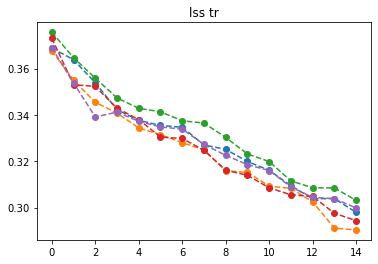

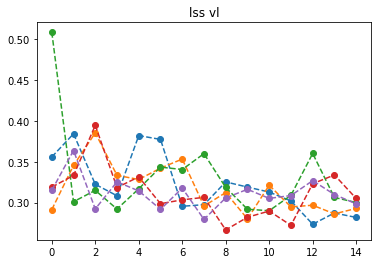

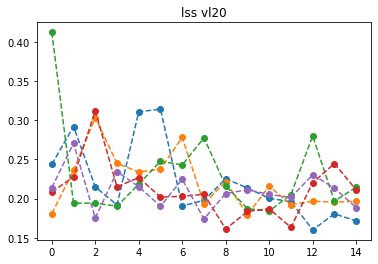

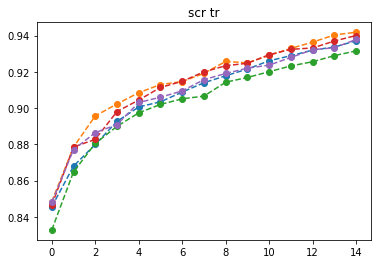

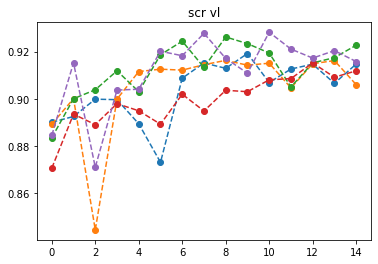

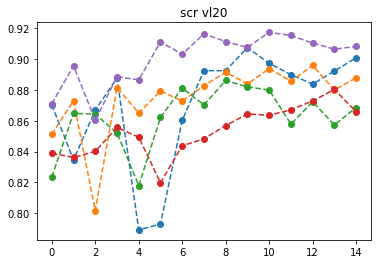

In [23]:
for mtrc in ['lss', 'scr']:
    for k in ['tr','vl','vl20']:
        plt.title(f'{mtrc} {k}')
        for fld in param.FLDS2USE:
            plt.plot(results['fld2stats'][fld][mtrc][k], 'o--')
        plt.show()

# oofs

In [24]:
vls = []
for fld in param.FLDS2USE:
    _,vl=fld2trvl[fld]
    vls += list(vl)
len(vls), vls[:10]

(58032, [0, 13, 16, 19, 27, 29, 31, 54, 55, 60])

## only last epoch

In [25]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:,-1])
    oofs += list(oof)
    
roc_auc(dftrn.target.iloc[vls], oofs)

0.913146082017659

## only best_scr epoch

In [26]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc = results['fld2stats'][fld]['best_epc']
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9185779942572936

## avg all epochs

In [27]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof.mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9239236836696187

## avg last m epochs

In [ ]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:, -1:].mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

In [61]:
def get_oof_avg_last_m(m):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, -m:].mean(1))
        oofs += list(oof)
    return oofs

In [62]:
for m in range(1, 6):
    oofs = get_oof_avg_last_m(m)
    print(m, roc_auc(dftrn.target.iloc[vls], oofs))

1 0.913146082017659
2 0.9199050875437063
3 0.9224922147971405
4 0.92395958933032
5 0.925460487044034


## avg last m epochs before epo-q

In [52]:
def get_oof_avg_last_m_before_q(m,q):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, q-m:q].mean(1))
        oofs += list(oof)
    return oofs

In [59]:
for m in range(1, 10):
    oofs = get_oof_avg_last_m_before_q(m, 15)
    print(m, roc_auc(dftrn.target.iloc[vls], oofs))

1 0.913146082017659
2 0.9199050875437063
3 0.9224922147971405
4 0.92395958933032
5 0.925460487044034
6 0.9262690067723784
7 0.9265823001375799
8 0.9268265219410113
9 0.926818646983256


# submissions

## only last epoch - lb914

In [33]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{param.EPOCHS-1}.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.16397730290047258


,image_name,target
0,ISIC_0052060,0.056340
1,ISIC_0052349,0.058993
2,ISIC_0058510,0.053108


fld 1 0.18574257226934995


,image_name,target
0,ISIC_0052060,0.053010
1,ISIC_0052349,0.054399
2,ISIC_0058510,0.137417


fld 2 0.1925672048105533


,image_name,target
0,ISIC_0052060,0.135004
1,ISIC_0052349,0.063251
2,ISIC_0058510,0.095181


fld 3 0.18874438590711962


,image_name,target
0,ISIC_0052060,0.088978
1,ISIC_0052349,0.037892
2,ISIC_0058510,0.068537


fld 4 0.17745807666768204


,image_name,target
0,ISIC_0052060,0.090414
1,ISIC_0052349,0.007577
2,ISIC_0058510,0.051177


0.18169790851103623


,image_name,target
0,ISIC_0052060,0.084749
1,ISIC_0052349,0.044423
2,ISIC_0058510,0.081084


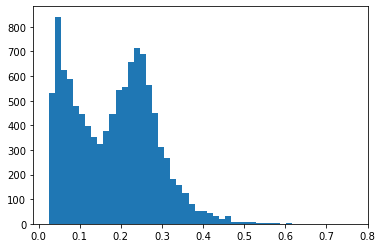

In [34]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [35]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlylast.csv', index=False)

## only best_scr epoch - lb911

In [36]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.0


,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0


fld 1 0.16397730290047258


,image_name,target
0,ISIC_0052060,0.056340
1,ISIC_0052349,0.058993
2,ISIC_0058510,0.053108


fld 2 0.18574257226934995


,image_name,target
0,ISIC_0052060,0.053010
1,ISIC_0052349,0.054399
2,ISIC_0058510,0.137417


fld 3 0.20118787141094333


,image_name,target
0,ISIC_0052060,0.089933
1,ISIC_0052349,0.065128
2,ISIC_0058510,0.089614


fld 4 0.18874438590711962


,image_name,target
0,ISIC_0052060,0.088978
1,ISIC_0052349,0.037892
2,ISIC_0058510,0.068537


0.14793042649757787


,image_name,target
0,ISIC_0052060,0.057652
1,ISIC_0052349,0.043282
2,ISIC_0058510,0.069735


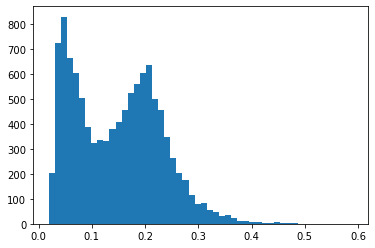

In [37]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [38]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlybestscr.csv', index=False)

## avg last m epochs - lb909(last2)906(last4)

In [63]:
m = 2 #4

In [64]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-m, param.EPOCHS):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 0 epc 11 0.1900425247045151


,image_name,target
0,ISIC_0052060,0.096365
1,ISIC_0052349,0.037327
2,ISIC_0058510,0.064300


fld 0 epc 12 0.14902971401807388


,image_name,target
0,ISIC_0052060,0.064535
1,ISIC_0052349,0.034554
2,ISIC_0058510,0.044598


fld 0 epc 13 0.16529026867965602


,image_name,target
0,ISIC_0052060,0.067424
1,ISIC_0052349,0.069038
2,ISIC_0058510,0.104477


fld 0 epc 14 0.16397730290047258


,image_name,target
0,ISIC_0052060,0.056340
1,ISIC_0052349,0.058993
2,ISIC_0058510,0.053108


fld 1 epc 11 0.179711880153068


,image_name,target
0,ISIC_0052060,0.062789
1,ISIC_0052349,0.055413
2,ISIC_0058510,0.093347


fld 1 epc 12 0.18269776144135796


,image_name,target
0,ISIC_0052060,0.047869
1,ISIC_0052349,0.073830
2,ISIC_0058510,0.070560


fld 1 epc 13 0.18652484707366573


,image_name,target
0,ISIC_0052060,0.058239
1,ISIC_0052349,0.057599
2,ISIC_0058510,0.145722


fld 1 epc 14 0.18574257226934995


,image_name,target
0,ISIC_0052060,0.053010
1,ISIC_0052349,0.054399
2,ISIC_0058510,0.137417


fld 2 epc 11 0.20032123160551768


,image_name,target
0,ISIC_0052060,0.035813
1,ISIC_0052349,0.040999
2,ISIC_0058510,0.206094


fld 2 epc 12 0.2492122772890157


,image_name,target
0,ISIC_0052060,0.166675
1,ISIC_0052349,0.126030
2,ISIC_0058510,0.201656


fld 2 epc 13 0.19288538962256238


,image_name,target
0,ISIC_0052060,0.075448
1,ISIC_0052349,0.057705
2,ISIC_0058510,0.079639


fld 2 epc 14 0.1925672048105533


,image_name,target
0,ISIC_0052060,0.135004
1,ISIC_0052349,0.063251
2,ISIC_0058510,0.095181


fld 3 epc 11 0.14414867581679067


,image_name,target
0,ISIC_0052060,0.058239
1,ISIC_0052349,0.052038
2,ISIC_0058510,0.089773


fld 3 epc 12 0.20118787141094333


,image_name,target
0,ISIC_0052060,0.089933
1,ISIC_0052349,0.065128
2,ISIC_0058510,0.089614


fld 3 epc 13 0.21580656009051055


,image_name,target
0,ISIC_0052060,0.148047
1,ISIC_0052349,0.033526
2,ISIC_0058510,0.200558


fld 3 epc 14 0.18874438590711962


,image_name,target
0,ISIC_0052060,0.088978
1,ISIC_0052349,0.037892
2,ISIC_0058510,0.068537


fld 4 epc 11 0.19818317233217964


,image_name,target
0,ISIC_0052060,0.074500
1,ISIC_0052349,0.059976
2,ISIC_0058510,0.109897


fld 4 epc 12 0.21177347843088598


,image_name,target
0,ISIC_0052060,0.094510
1,ISIC_0052349,0.082697
2,ISIC_0058510,0.109897


fld 4 epc 13 0.19303630716554346


,image_name,target
0,ISIC_0052060,0.106133
1,ISIC_0052349,0.063366
2,ISIC_0058510,0.110279


fld 4 epc 14 0.17745807666768204


,image_name,target
0,ISIC_0052060,0.090414
1,ISIC_0052349,0.007577
2,ISIC_0058510,0.051177


0.18841707511947414


,image_name,target
0,ISIC_0052060,0.083513
1,ISIC_0052349,0.056567
2,ISIC_0058510,0.106292


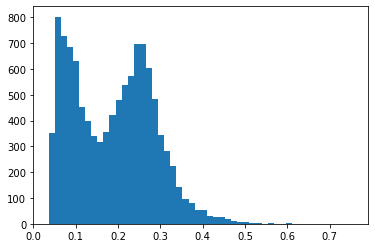

In [65]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [66]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_avglast{m}.csv', index=False)

## avg last m epochs before epo-q

In [45]:
m = 2
q = 14

In [46]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(q-m, q):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 0 epc 12 0.14902971401807388


,image_name,target
0,ISIC_0052060,0.064535
1,ISIC_0052349,0.034554
2,ISIC_0058510,0.044598


fld 0 epc 13 0.16529026867965602


,image_name,target
0,ISIC_0052060,0.067424
1,ISIC_0052349,0.069038
2,ISIC_0058510,0.104477


fld 1 epc 12 0.18269776144135796


,image_name,target
0,ISIC_0052060,0.047869
1,ISIC_0052349,0.073830
2,ISIC_0058510,0.070560


fld 1 epc 13 0.18652484707366573


,image_name,target
0,ISIC_0052060,0.058239
1,ISIC_0052349,0.057599
2,ISIC_0058510,0.145722


fld 2 epc 12 0.2492122772890157


,image_name,target
0,ISIC_0052060,0.166675
1,ISIC_0052349,0.126030
2,ISIC_0058510,0.201656


fld 2 epc 13 0.19288538962256238


,image_name,target
0,ISIC_0052060,0.075448
1,ISIC_0052349,0.057705
2,ISIC_0058510,0.079639


fld 3 epc 12 0.20118787141094333


,image_name,target
0,ISIC_0052060,0.089933
1,ISIC_0052349,0.065128
2,ISIC_0058510,0.089614


fld 3 epc 13 0.21580656009051055


,image_name,target
0,ISIC_0052060,0.148047
1,ISIC_0052349,0.033526
2,ISIC_0058510,0.200558


fld 4 epc 12 0.21177347843088598


,image_name,target
0,ISIC_0052060,0.094510
1,ISIC_0052349,0.082697
2,ISIC_0058510,0.109897


fld 4 epc 13 0.19303630716554346


,image_name,target
0,ISIC_0052060,0.106133
1,ISIC_0052349,0.063366
2,ISIC_0058510,0.110279


0.19474444752222272


,image_name,target
0,ISIC_0052060,0.091881
1,ISIC_0052349,0.066347
2,ISIC_0058510,0.115700


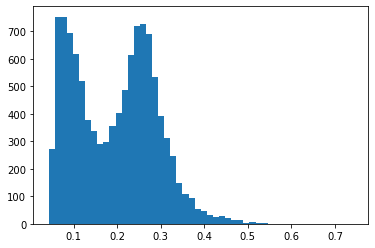

In [47]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [48]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_{m}before{q}.csv', index=False)

# fin

In [49]:
param.__dict__

{'PRFX': 'Mel0710A2',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0909A224',
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'EPOCHS': 15,
 'BS': 48,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'USE_LAST_M_EPCS': 5,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 8,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [50]:
!nvidia-smi

Sat Jul 11 18:07:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   61C    P0   138W / 300W |  15673MiB / 16160MiB |     33%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  